## Notebook 2 - Operationalize Machine Learning Workflow using ML Pipelines

##### Please ensure you have executed notebook '1_simple_xgboost_training_pipeline.ipynb' before you start with this notebook

##### This notebook creates  Kubeflow Pipelines that runs distributed training using DistributedDataParallel (DDP) on Amazon SageMaker service. 



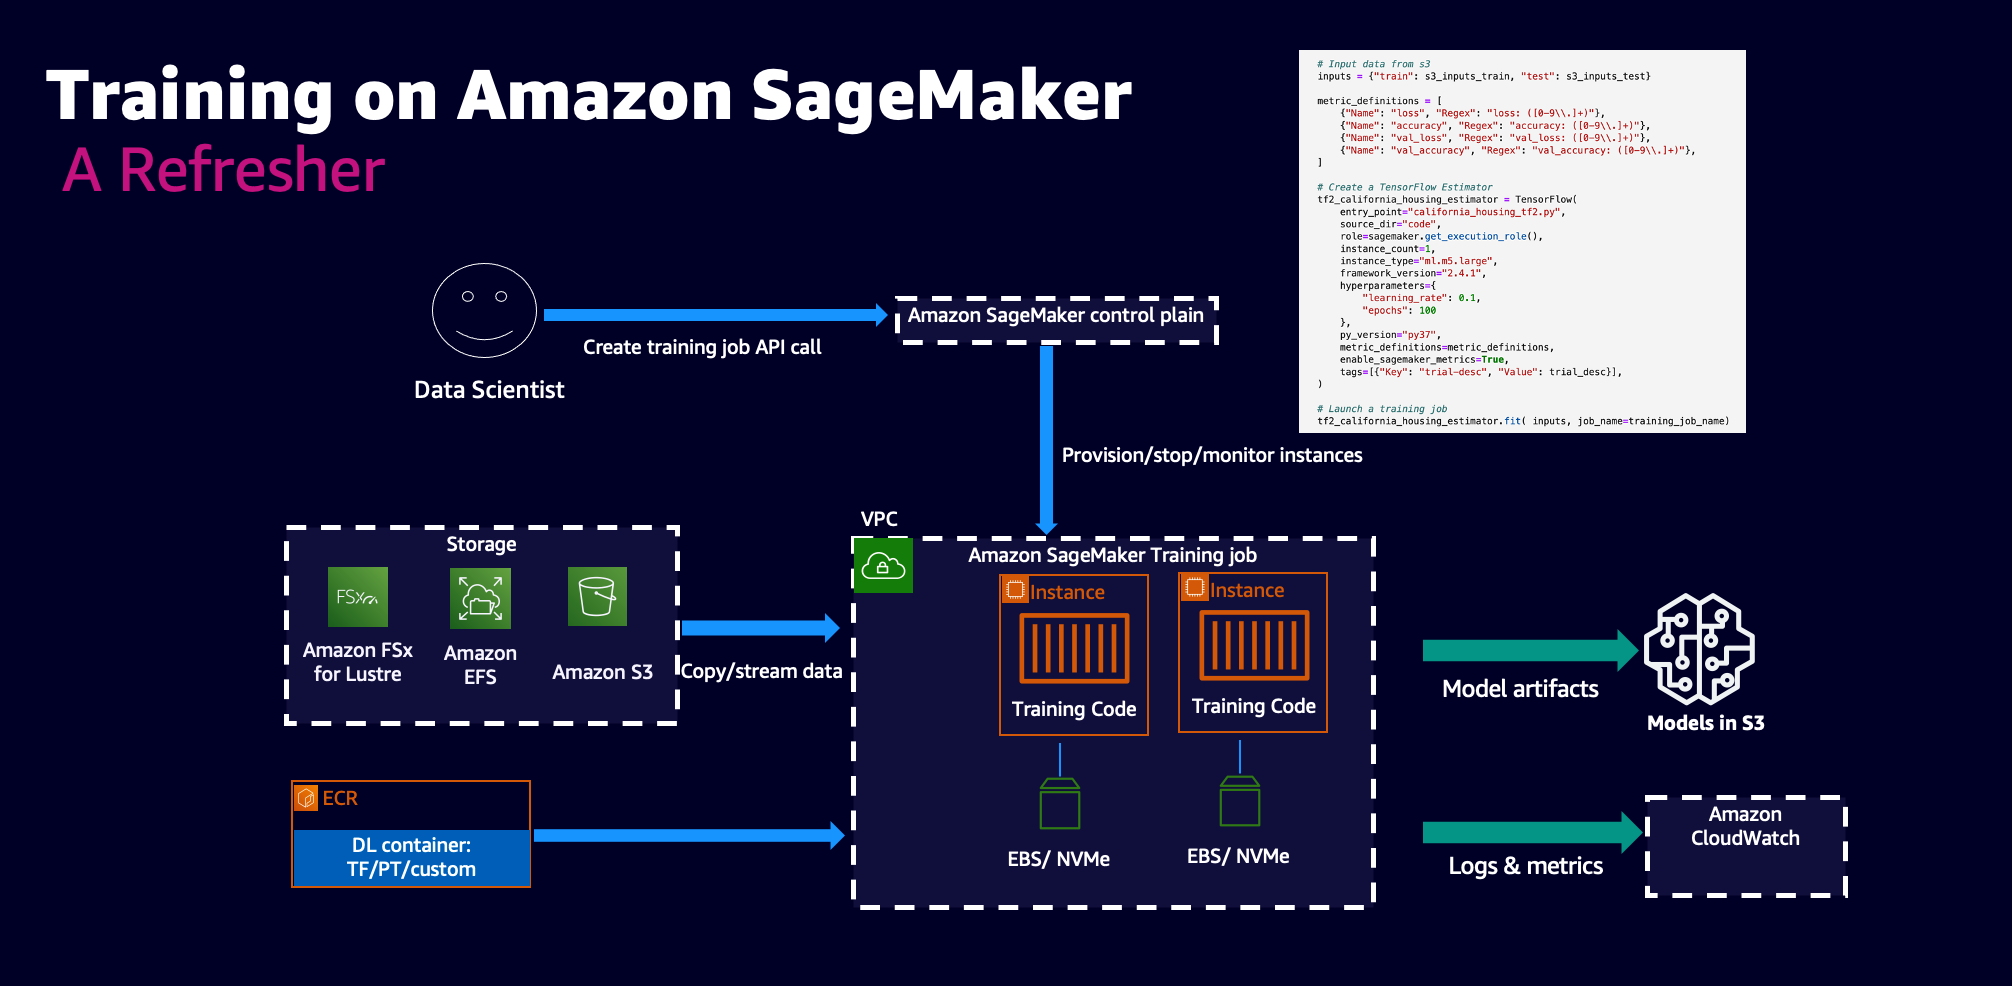

In [ ]:
# 1. !pip install sagemaker
# 2. Wait for the installation to complete
# 3. Restart the Kernel (Go to 'Kernel' Menu -> Click 'Restart Kernel...')
# 4. Run the next cell  

!pip install sagemaker

In [ ]:
# Import necessary libraries. Make sure you have restarted the kernel  

import kfp
from kfp import components
from kubeflow.training.utils import utils
from kfp import dsl
from kfp import compiler

import os
import yaml
import json
from kubeflow.training import PyTorchJobClient
import time
import boto3
import kfp.components as comp

# Import SageMaker specific libraries
import sagemaker
import boto3
import random, string

In [ ]:
# Initialize global variables 

user_namespace = utils.get_default_target_namespace()
target_region='us-west-2'

aws_dlc_sagemaker_train_image='763104351884.dkr.ecr.'+target_region+'.amazonaws.com/pytorch-training:1.8.0-gpu-py3'
aws_dlc_sagemaker_serving_image='763104351884.dkr.ecr.'+target_region+'.amazonaws.com/pytorch-inference:1.6.0-cpu-py3'

## Create SageMaker session and default bucket

In [ ]:
# Get role that will be assigned to Sagemaker to call S3 apis 
# (Please make sure you have created a role with the name sagemakerrole. Add managed policies AmazonSageMakerFullAccess and AmazonS3FullAccess to give SageMaker access to S3 buckets. This role is used by SageMaker job submitted as part of Kubeflow Pipelines step.)

sagemakerole=!aws iam get-role --role-name sagemakerrole --output text --query 'Role.Arn'
sagemakerole

In [ ]:
!aws configure set default.region {target_region}

In [ ]:
# Initialize SageMaker session

sess = boto3.Session()
sm= sess.client('sagemaker',region_name=target_region)

# Use role as shared in WorkShop Steps 
role= sagemakerole[0]
sagemaker_session = sagemaker.Session(boto_session=sess)
dataset_folder = 'datasets'

In [ ]:
# SageMaker default bucket
bucket_name = sagemaker_session.default_bucket()
job_folder      = 'jobs'
dataset_folder  = 'datasets'
local_dataset = 'cifar10'
pytorchjob_name   = f'pytorch-dist-gpu-{time.strftime("%Y-%m-%d-%H-%M-%S-%j", time.gmtime())}'

bucket_name

# Download the Cifar 10 dataset

In [ ]:
#Download CIFAR10 Dataset. Ignore javascript error
import torchvision
cifar10_dataset = torchvision.datasets.CIFAR10('cifar10-dataset', 
                                     train=True, 
                                     download=True)



In [ ]:
#Upload CIFAR10 Dataset to Amazon S3 bucket
datasets = sagemaker_session.upload_data(path='cifar10-dataset', 
                                         key_prefix=f'{dataset_folder}/cifar10-dataset')

datasets

## Set up SageMaker Component Training Job

In [ ]:
# Loads SageMaker training components v2 for Kubeflow pipeline from the URL 
sagemaker_train_ack_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/aws/sagemaker/TrainingJob/component.yaml')

# Loads SageMaker components v1 for Kubeflow pipeline from the URL 
sagemaker_model_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/cb36f87b727df0578f4c1e3fe9c24a30bb59e5a2/components/aws/sagemaker/model/component.yaml')
sagemaker_deploy_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/cb36f87b727df0578f4c1e3fe9c24a30bb59e5a2/components/aws/sagemaker/deploy/component.yaml')

In [ ]:
# Upload the training and inference script to the S3 bucket to be accessed by SageMaker training and deployment job
!tar cvfz sourcedir.tar.gz --exclude=".ipynb*" -C code . 
source_s3 = sagemaker_session.upload_data(path='sourcedir.tar.gz', key_prefix='training-scripts')
print('\nUploaded to S3 location:')
print(source_s3)

In [ ]:
def training_input(datasets):
    return [
        {
            "channelName": "train",
            "dataSource": {
                "s3DataSource": {
                    "s3DataType": "S3Prefix",
                    # change it to your input path of the train data: s3://<YOUR BUCKET>/mnist_kmeans_example/train_data
                    "s3URI": str(datasets),
                    "s3DataDistributionType": "FullyReplicated",
                },
            },
            "compressionType": "None",
            "RecordWrapperType": "None",
            "InputMode": "File",
        }
    ]


In [ ]:
def training_output(s3_bucket_name):
    return {"s3OutputPath": f"s3://{s3_bucket_name}"}

In [ ]:
def get_s3_model_artifact(model_artifacts) -> str:
        import ast

        model_artifacts = ast.literal_eval(model_artifacts)
        return model_artifacts["s3ModelArtifacts"]

get_s3_model_artifact_op = kfp.components.create_component_from_func(
        get_s3_model_artifact, output_component_file="get_s3_model_artifact.yaml"
    )

# Set up PyTorch Operator Training Job

# Create hybrid Kubeflow Pipeline

In [ ]:
# Create job name for tracking kuberenets PyTorchJob custom resource or SageMaker training job
pytorch_distributed_jobname=f'pytorch-cnn-dist-job-{time.strftime("%Y-%m-%d-%H-%M-%S-%j", time.gmtime())}'

# Create Kubeflow Pipeline using Amazon SageMaker Service
@dsl.pipeline(name="PyTorch Training pipeline", description="Sample training job test")
def pytorch_cnn_pipeline(region=target_region,
                           training_input_mode='File',
                           namespace=user_namespace,
                           train_image=aws_dlc_sagemaker_train_image,
                           serving_image=aws_dlc_sagemaker_serving_image,
                           volume_size='54',
                           max_run_time='86400',
                           learning_rate='0.01',
                           pytorch_backend='gloo',
                           training_job_name=pytorch_distributed_jobname, 
                           instance_type='ml.p3.2xlarge',
                           instance_count='2',
                           network_isolation='False',
                           traffic_encryption='False',
                           spot_instance='False'
                            ):
    
    # Step to run training on SageMaker using SageMaker Components V2 for Pipeline.  
    training = sagemaker_train_ack_op(
        region=region,
        algorithm_specification='{ \
                "trainingImage":"' + str(train_image) + '", \
                "trainingInputMode": "File" \
                }', 
        training_job_name=training_job_name,
        hyper_parameters='{ \
            "backend":"' + str(pytorch_backend) + '", \
            "batch-size": "64", \
            "epochs": "3", \
            "lr":"' + str(learning_rate) + '", \
            "model-type": "custom", \
            "sagemaker_container_log_level": "20", \
            "sagemaker_program": "cifar10-distributed-gpu-final.py", \
            "sagemaker_region":"' + str(region) + '", \
            "sagemaker_submit_directory":"' + source_s3 + '" \
            }',
        resource_config='{"instanceType":"' + str(instance_type) + '", \
                  "instanceCount":' + str(instance_count) + ', \
                  "volumeSizeInGB": 50 \
                  }', 
        input_data_config=training_input(datasets),     
        output_data_config=training_output(bucket_name),    
        enable_network_isolation=network_isolation,
        enable_inter_container_traffic_encryption=traffic_encryption,
        role_arn=role,
        stopping_condition={"maxRuntimeInSeconds": 3600}
    )
    
    model_artifact_url = get_s3_model_artifact_op(
        training.outputs["model_artifacts"]
    ).output
    
    # This step creates SageMaker Model which refers to model artifacts and inference script to deserialize the input image
    create_model = sagemaker_model_op(
        region=region,
        model_name=training_job_name,
        image=serving_image,
        model_artifact_url=model_artifact_url,
        network_isolation=network_isolation,
        environment='{"SAGEMAKER_CONTAINER_LOG_LEVEL": "20", \
               "SAGEMAKER_PROGRAM": "inference.py", \
               "SAGEMAKER_REGION":"' + str(region) + '", \
               "SAGEMAKER_SUBMIT_DIRECTORY": "'+str(model_artifact_url)+'" \
               }',
        role=role
    )

    # This step creates SageMaker Endpoint which will be called to run inference
    prediction = sagemaker_deploy_op(
        region=region,
        model_name_1=create_model.output,
        instance_type_1='ml.c5.xlarge'
    )
        
    #Disable pipeline cache
    training.execution_options.caching_strategy.max_cache_staleness = "P0D"


# Compile the pipeline

In [ ]:
# DSL Compiler that compiles pipeline functions into workflow yaml.

kfp.compiler.Compiler().compile(pytorch_cnn_pipeline, "pytorch_cnn_pipeline.yaml")

# Execute the Pipeline using Kubeflow Pipeline Client

In [ ]:
# Connect to Kubeflow Pipelines using the Kubeflow Pipelines SDK client
client = kfp.Client()

experiment = client.create_experiment(name="kubeflow")

# Run a specified pipeline 
my_run = client.run_pipeline(experiment.id, "pytorch_cnn_pipeline", "pytorch_cnn_pipeline.yaml")

# Please click “Run details” link generated below this cell to view your pipeline. You can click every pipeline step to see logs. 

## Track and wait for the above pipeline to complete. After it completes, invoke the SageMaker Endpoint using sample image 

In [ ]:
#Read a sample input image
import json, boto3, numpy as np
client = boto3.client('runtime.sagemaker')

file_name = '1000_dog.png'
with open(file_name, 'rb') as f:
    payload = f.read()

## Ensure you update the EndpointName

In [ ]:
# Invole SageMaker Endpoint. Ensure you update the endpoint
response = client.invoke_endpoint(EndpointName='Endpoint-cnn-dist-job-2022-10-03-18-49-51-276', 
                                   ContentType='application/x-image', 
                                   Body=payload)

pred = json.loads(response['Body'].read().decode())

output_vector_list=pred['score']

# Get outout vector of 10 classes 
output_vector = output_vector_list[0]

# Find the class with highest probability
max=output_vector[0]
index = 0
for i in range(1,len(output_vector)):
    if output_vector[i] > max:
        max = output_vector[i]
        index = i
        
print(f'Index of the maximum value is : {index}')         

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(labels[index])